In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import json
import matplotlib.pyplot as plt
import os
import random

In [2]:
#agonist = "ADP_META"
agonists = ["ADP_META","CRP","PAR1","PAR4"]

pfcs = []
for ago in agonists:
    pfc = pd.read_csv("pfc_results/%s.tsv" % ago,sep="\t",usecols=["RSID","MLOG10P","AAF"])
    pfc = pfc.loc[pfc.AAF > 0.01]
    pfc = pfc.sort_values("MLOG10P",ascending=False)
    pfc["agonist"] = ago
    pfc["hit_rank"] = np.arange(pfc.shape[0])
    pfcs.append(pfc)
pfc = pd.concat(pfcs,axis=0)

In [3]:
pfc = pfc.groupby("RSID").agg({"MLOG10P":"max","AAF":"median"}).reset_index()

In [4]:
pfc_snps = pfc.RSID.unique().tolist()
pfc_snps = [s for s in pfc_snps if s != "."]

In [5]:
draganas_gwas = pd.read_excel("draganas_gwas.xlsx")

In [6]:
draganas_gwas.head()

,Associated Blood Index,Novel vs Astle 2016,Locus ID,Associated Blood Index Class,Unique Variant ID,Gene Symbol(s) for Most Serious Consequence,rsID (where available),INFO SCORE,Chr (GRCh37),BP (GRCh37),...,"(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)",(UNIVAR) Standard Error of Estimator,(UNIVAR) -log10 P,(UNIVAR) Unadjusted R2,"(MULTI) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)",(MULTI) Standard Error of Estimate,(MULTI) -log10 P,Most Serious VEP Consequence of Variant,VEP IMPACT of Most Serious Consequence,Ensembl Gene ID(s) for Most Serious Consequence
0,RET#,True,1.0,Red Cell,1:1692321_T_C,NADK,rs1107910,0.981899,1,1692321,...,-0.013854,0.002160,9.848282,0.000095,-0.013985,0.002248,9.302960,intron_variant,MODIFIER,ENSG00000008130
1,RET%,True,1.0,Red Cell,1:1692321_T_C,NADK,rs1107910,0.981899,1,1692321,...,-0.013599,0.002165,9.470071,0.000092,-0.013741,0.002248,9.005840,intron_variant,MODIFIER,ENSG00000008130
2,MSCV,False,2.0,Red Cell,1:2146165_C_A,RP11-181G12.4,rs78265569,0.976555,1,2146165,...,-0.027229,0.003664,12.970848,0.000119,-0.028861,0.003916,12.767629,intron_variant,MODIFIER,ENSG00000234396
3,MCHC,False,2.0,Red Cell,1:2146165_C_A,RP11-181G12.4,rs78265569,0.976555,1,2146165,...,0.023502,0.003900,8.775455,0.000089,0.024565,0.003933,9.373581,intron_variant,MODIFIER,ENSG00000234396
4,HLSR#,False,2.0,Red Cell,1:2147874_A_G,RP11-181G12.4,rs10910028,0.974162,1,2147874,...,0.038157,0.004105,19.830782,0.000199,0.040770,0.004282,20.764373,intron_variant,MODIFIER,ENSG00000234396


(array([663146., 631992., 593234., 614991., 653486., 732021., 812657.,
        898007., 953133., 929492.]),
 array([-1.99956592, -1.80004142, -1.60051693, -1.40099243, -1.20146793,
        -1.00194343, -0.80241893, -0.60289443, -0.40336994, -0.20384544,
        -0.00432094]),
 <BarContainer object of 10 artists>)

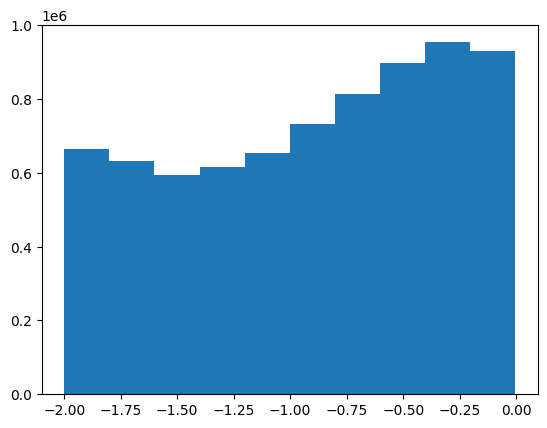

In [7]:
plt.hist(np.log10(pfc["AAF"]))

(array([  29.,   64.,  128.,  229.,  425.,  747.,  977., 2132., 5356.,
        6813.]),
 array([-4.29242982e+00, -3.86354488e+00, -3.43465994e+00, -3.00577499e+00,
        -2.57689005e+00, -2.14800510e+00, -1.71912016e+00, -1.29023521e+00,
        -8.61350269e-01, -4.32465324e-01, -3.58038001e-03]),
 <BarContainer object of 10 artists>)

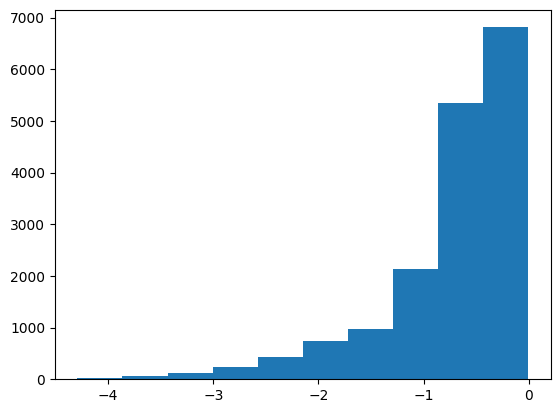

In [8]:
plt.hist(np.log10(draganas_gwas["Alternative Allele Frequency"]))

In [9]:
draganas_hits = draganas_gwas.loc[
    draganas_gwas["Associated Blood Index"].isin(["PLT#","MPV","PCT","PDW"]) & 
    (draganas_gwas["Alternative Allele Frequency"] > 0.01) & 
    (draganas_gwas["Alternative Allele Frequency"] < 0.99) &
    (draganas_gwas["rsID (where available)"].str.contains("rs")),
    "rsID (where available)"].unique().tolist()

In [10]:
len(draganas_hits)

2177

In [11]:
found = list(set(draganas_hits).intersection(set(pfc_snps)))
len(found)

1518

In [12]:
missing = list(set(draganas_hits).difference(set(pfc_snps)))

In [13]:
len(missing)

659

(array([ 11.,  18.,  21.,  46.,  53.,  67., 135., 162., 218., 142.]),
 array([-1.9848499 , -1.78745707, -1.59006423, -1.3926714 , -1.19527857,
        -0.99788574, -0.80049291, -0.60310008, -0.40570725, -0.20831441,
        -0.01092158]),
 <BarContainer object of 10 artists>)

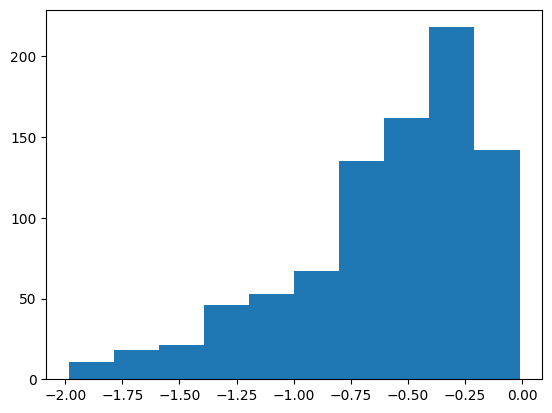

In [14]:
plt.hist(np.log10(draganas_gwas.loc[draganas_gwas["rsID (where available)"].isin(missing),"Alternative Allele Frequency"]))

In [15]:
missing[:5]

['rs74267315', 'rs77642031', 'rs74811610', 'rs11459029', 'rs61528333']

In [16]:
if os.path.exists("proxies.json"):
    with open("proxies.json","r") as infile:
        proxies = json.load(infile)

In [4]:
with requests.Session() as s:
    random.shuffle(missing)
    for i, m in enumerate(missing):
        if m in proxies and proxies[m] != ".":
            continue
        if i % 1 == 0:
            print("%d (%d) / %d" % (i,len(proxies),len(missing)))
            
        # First, check if m is in 1000G ref panel. If not, stop here
        if not "1000Genomes" in s.get("https://api.ncbi.nlm.nih.gov/variation/v0/refsnp/%d" % int(m[2:])).text:
            print("%s is not in reference panel (NCBI)" % m)
            proxies[m] = "not in reference panel (NCBI)"
            continue
            
        URL = "https://ldlink.nih.gov/LDlinkRest/ldproxy"
        PARAMS = {
            "var":m,
            "pop":"GBR",
            "r2_d":"r2",
            "window":int(1e5),
            "genome_build":"grch37",
            "token":"14ad36e8238c"
        }
        try:
            #time.sleep()
            print("Sending request for %s..." % m)
            r = s.get(url = URL, params = PARAMS,timeout=12*60)
            
        except requests.Timeout as e:
            print("Timeout %s" % m)
            proxies[m] = "timeout..."
            continue
        try:
            snp = pd.read_csv(StringIO(r.text),sep="\t")
            candidate_proxies = snp.loc[snp.RS_Number.isin(pfc_snps)]
            if candidate_proxies.shape[0] == 0:
                print("No proxy for %s" % m)
                proxies[m] = "No proxy found"
            else:
                proxies[m] = candidate_proxies.RS_Number.iloc[0]
                print("Found proxy for %s : %s" % (m, candidate_proxies.RS_Number.iloc[0]))
        except:
            if "not in 1000G reference panel" in r.text:
                print("%s is not in reference panel" % m)
                proxies[m] = "not in reference panel"
            elif "Concurrent API" in r.text:
                continue
            else:
                print(r.text)
                proxies[m] = "other error : %s" % json.loads(r.text)["error"]

NameError: name 'requests' is not defined

In [31]:
with open("proxies.json", "w") as outfile:
    json.dump(proxies, outfile)

In [21]:
r = json.loads(requests.get("https://api.ncbi.nlm.nih.gov/variation/v0/refsnp/35383388" ).text)

In [102]:
draganas_hits_in_pfc = set(list(proxies.values()) + list(set(draganas_hits).intersection(set(pfc_snps))))
len(draganas_hits_in_pfc)

1935

In [40]:
pfc["P"] = np.power(10,-pfc["MLOG10P"])

In [42]:
pfc.loc[pfc.RSID == "rs17881225"]

,RSID,MLOG10P,AAF,P
2836628,rs17881225,2.736,0.1109,0.001837


In [1]:
hippo_snps = [
"rs12566888",
"rs1434282",
"rs41315846",
"rs13412535",
"rs78909033",
"rs1354034",
"rs13067286",
"rs76445378",
"rs922140",
"rs17881225",
"rs55665228",
"rs61751937",
"rs10886430",
"rs7123827",
"rs11553699",
"rs61978213",
"rs12905925",
"rs8057254",
"rs12445050",
"rs11078475",
"rs1654425"]

In [2]:
len(hippo_snps)

21

In [3]:
p_values_hippo = pfc.loc[pfc.RSID.isin(hippo_snps),"P"]
p_values_dragana = pfc.loc[pfc.RSID.isin(draganas_hits_in_pfc),"P"]

NameError: name 'pfc' is not defined

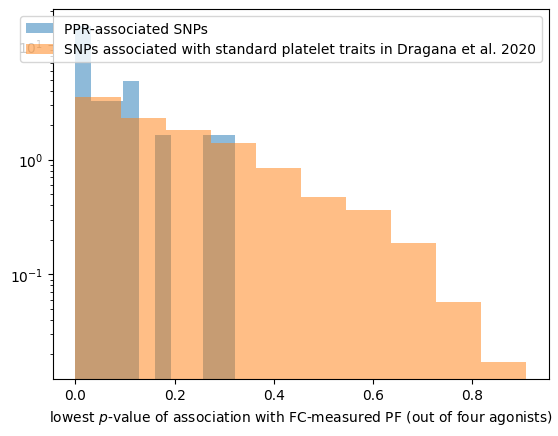

In [52]:
plt.hist(p_values_hippo,density=True,alpha=.5,label="PPR-associated SNPs")
plt.hist(p_values_dragana,density=True,alpha=.5,label="SNPs associated with standard platelet traits in Dragana et al. 2020")
plt.yscale("log")
plt.xlabel("lowest $p$-value of association with FC-measured PF (out of four agonists)")
plt.legend();

Text(0, 0.5, "Hippolyte's hits")

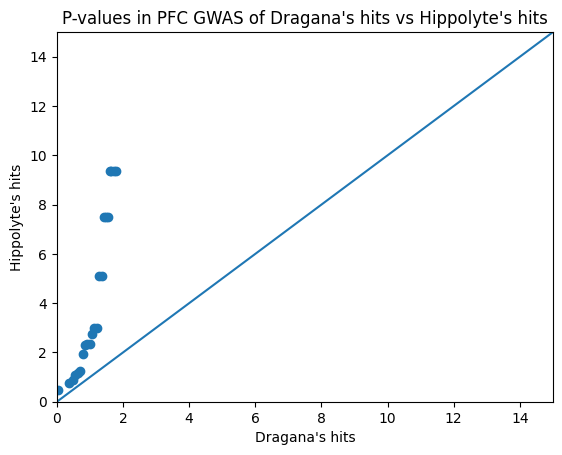

In [100]:
quantiles = np.logspace(-5,0,100)
plt.title("P-values in PFC GWAS of Dragana's hits vs Hippolyte's hits")
plt.scatter(-np.log10(np.quantile(p_values_dragana,quantiles,method="closest_observation")),
            -np.log10(np.quantile(p_values_hippo,quantiles,method="closest_observation")))
plt.xlim((0,15))
plt.ylim((0,15))
plt.plot([0,15],[0,15])
#plt.yscale("log")
plt.xlabel("Dragana's hits")
plt.ylabel("Hippolyte's hits")
#plt.legend()

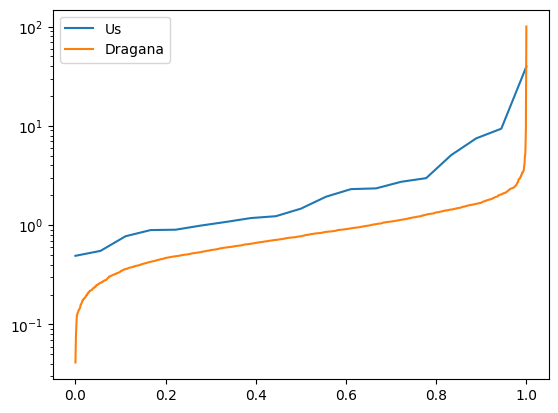

In [66]:
plt.plot(np.linspace(0,1,p_values_hippo.shape[0]),-np.log10(p_values_hippo.sort_values()[::-1]),label="Us")
plt.plot(np.linspace(0,1,p_values_dragana.shape[0]),-np.log10(p_values_dragana.sort_values()[::-1]),label="Dragana")
#plt.xscale("log")
plt.yscale("log")
plt.legend();
# TODO: proper QQ-plot
# Send data to Will (Extended data fig. 3)
# QQ-plot of MAF

In [64]:
known_hits = [
    "rs7097060", #ADRA2A
    "rs1207486385", #KCNJ18
]

In [65]:
pfc.loc[pfc.RSID.isin(known_hits)]

,RSID,MLOG10P,AAF,P
5545872,rs7097060,0.9538,0.1625,0.111224


In [101]:
pfc.loc[pfc.RSID.isin(draganas_hits)].to_csv("draganas_hits_pfc_gwas.csv")
pfc.loc[pfc.RSID.isin(draganas_hits_in_pfc)].to_csv("draganas_hits_with_proxies_pfc_gwas.csv")
pfc.loc[pfc.RSID.isin(hippo_snps)].to_csv("hippolytes_hits_pfc_gwas.csv")